In [2]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

folder = "./data/20210921/"

In [3]:
dfp_train = pd.read_csv(folder + "train.csv")
dfp_test = pd.read_csv(folder + "test.csv")
print(len(dfp_train))

dfp_mapping = pd.read_csv("./data/train_breath_mapping.csv")
dfp_train = pd.merge(dfp_train, dfp_mapping[dfp_mapping["type_record"] == "training"]["breath_id"], on=["breath_id"])
print(len(dfp_train))

dfp_train.sort_values(["breath_id", "time_step"], inplace=True)
dfp_test.sort_values(["breath_id", "time_step"], inplace=True)

6036000
4828800


In [9]:
# Get the sample for the clustering
dfp_clustering_breath_id = dfp_mapping[dfp_mapping["type_record"] == "training"].sample(frac=0.1, random_state=12)

In [10]:
column = "u_in"
X = []
for breath_id in tqdm(sorted(dfp_clustering_breath_id["breath_id"].unique().tolist())):
    dfp_data_breath_id = dfp_train[dfp_train["breath_id"] == breath_id]
    X.append(dfp_data_breath_id[column].tolist())

100%|██████████| 6036/6036 [00:22<00:00, 267.78it/s]


## Build projection with ED

In [11]:
%%time
euclidean_distance_X = euclidean_distances(X, X)
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=12)
projection_X = embedding.fit_transform(euclidean_distance_X)

CPU times: user 28min 51s, sys: 3min 4s, total: 31min 56s
Wall time: 9min 34s


In [12]:
projection_X[:,0]

array([-19.85359065, -38.78389189,  40.06101264, ...,  10.16564326,
       -40.64432507, -39.13619955])

In [13]:
dfp_projection = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "x" : projection_X[:,0],
    "y" : projection_X[:,1] 
})

In [14]:
dfp_projection.iloc[0]

breath_id    12.000000
x           -19.853591
y           -71.799791
Name: 0, dtype: float64

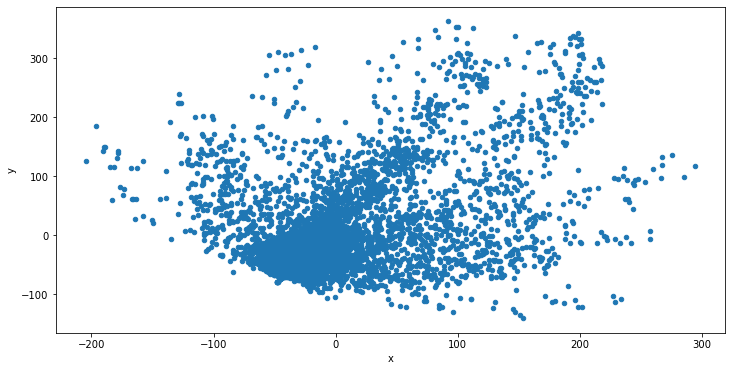

In [15]:
fig,ax=plt.subplots(figsize=(12,6))
dfp_projection.plot(ax=ax, x="x", y="y", kind="scatter")
plt.show()

## Build projection with DTW

In [16]:
from dtaidistance import dtw
import numpy as np

dtw_X = dtw.distance_matrix_fast(np.array(X))

In [17]:
embedding_dtw = MDS(n_components=2, dissimilarity="precomputed", random_state=12)
projection_X_dtw = embedding_dtw.fit_transform(dtw_X)

In [18]:
dfp_projection_dtw = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "x" : projection_X_dtw[:,0],
    "y" : projection_X_dtw[:,1] 
})

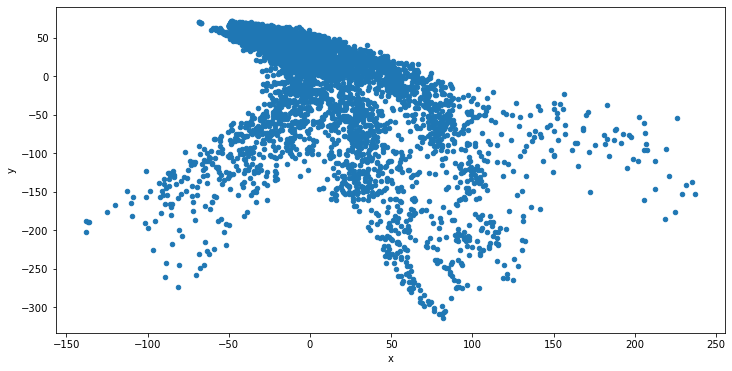

In [19]:
fig,ax=plt.subplots(figsize=(12,6))
dfp_projection_dtw.plot(ax=ax, x="x", y="y", kind="scatter")
plt.show()

## Build some clustering now

In [20]:
from sklearn.cluster import DBSCAN

In [21]:
clustering_euclidian_distance = DBSCAN(eps=3, min_samples=2).fit(projection_X)

In [22]:
clustering_euclidian_distance.labels_

array([0, 0, 1, ..., 3, 0, 0])

In [23]:
np.unique(clustering_euclidian_distance.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [24]:
clustering_dtw = DBSCAN(eps=3, min_samples=2).fit(projection_X_dtw)

In [25]:
np.unique(clustering_dtw.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [32]:
dfp_clusters_ed = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "cluster_ed" : clustering_euclidian_distance.labels_
})

dfp_clusters_dtw = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "cluster_dtw" : clustering_dtw.labels_
})

dfp_clusters = pd.merge(dfp_clusters_ed, dfp_clusters_dtw, on=["breath_id"])

In [33]:
dfp_clusters

100%|█████████▉| 6035/6036 [14:22<00:00,  7.00it/s]


,breath_id,cluster_ed,cluster_dtw
0,12,0,0
1,29,0,0
2,36,1,0
3,39,-1,1
4,43,0,0
...,...,...,...
6031,125696,0,0
6032,125702,0,0
6033,125707,3,0
6034,125739,0,0


In [65]:
for column in ["cluster_ed","cluster_dtw"]:
    dfp_agg_breath_id = dfp_clusters.groupby([column])["breath_id"].apply(list)
    dict_kernel = {}
    for cluster_id in dfp_agg_breath_id.index:
        breath_ids = dfp_agg_breath_id.iloc[cluster_id]
        u_in_avg = np.mean(np.array([dfp_train[dfp_train["breath_id"] == breath_id]["u_in"].tolist() for breath_id in breath_ids]), axis=0)
        dict_kernel[str(cluster_id)] = u_in_avg
    dfp_kernel = pd.DataFrame(dict_kernel).T
    dfp_kernel.to_csv(f"./data/clusters/{column}.csv")

In [55]:
u_in_avg

array([9.34926139e+01, 8.61411015e+01, 7.73674700e+01, 6.77489802e+01,
       5.94428526e+01, 5.12702733e+01, 4.30397366e+01, 3.50445547e+01,
       2.71090006e+01, 1.96419135e+01, 1.25796165e+01, 5.68168727e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.53368195e-02, 7.40634798e-01,
       1.36643815e+00, 1.90132056e+00, 2.36762950e+00, 2.75327322e+00,
       3.08354865e+00, 3.36455628e+00, 3.61075446e+00, 3.81531899e+00,
      

In [29]:
clustering_dtw.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
from dtaidistance import clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
cluster_idx = model1.fit(np.array(X))

100%|█████████▉| 6035/6036 [11:23<00:00,  8.81it/s]

In [27]:
dfp_clusters = pd.DataFrame({
    "breath_id" : sorted(dfp_clustering_breath_id["breath_id"].unique().tolist()),
    "cluster_model1" : cluster_idx
})

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [28]:
cluster_idx.keys()

dict_keys([0])